# Custom Loss Function in PyTorch

[to be edited]
    
    As you might know, that these past few years, there is a high interest to use deep learning model for insurance application. Every model's architectures are the same except on the last output nodes, we apply a log function as similar with the one used in GLM (Generalized Linear Model). But this also would initiate a new problem where we need to apply a loss function that is similar with GLM framework, i.e., log likelihood of the assumed distribution. Luckily there are an example to create such model for GLM with Poisson distribution. But what about Gamma distribution or even Tweedie distribution. Shouldn't these 2 distribution also have their own built-in function in PyTorch ? 

This notebook will try to create the Gamma and Tweedie log likelihood function that theoretically can mimick the GLM model for said distribution.  

In [ ]:
# General Data Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GLM Model
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.metrics import mean_poisson_deviance
from scipy.stats import gamma 

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F

In [115]:
np.random.seed(108)
n_obs = 100_000

model_df = pd.DataFrame({
    'variable_1' : np.random.choice(a=['a', 'b', 'c'], size=n_obs),
    'variable_2' : np.random.uniform(low=0, high=20, size=n_obs),
    'variable_3' : np.random.normal(loc = 0, scale = 1, size = n_obs),
    'exposure' : np.round(np.random.uniform(low=0.2, high=1, size=n_obs),4),
    })
model_df['lambda'] = (
    3.2 + 
    model_df['variable_1'].map({'a': 0.4, 'b': -0.3, 'c': 0.8}) - 
    0.2*model_df['variable_2'] + 
    1.2*np.cos(model_df['variable_3']) + 
    np.log(model_df['exposure'])
).clip(0)

model_df['claim_count'] = np.random.poisson(lam = model_df['lambda'])

# Claim Amount
model_df['gamma_shape'] = (
    152 + 
    model_df['variable_1'].map({'a': 41.3, 'b': 12.8, 'c': 83.2}) + 
    5.9*model_df['variable_2'] + 
    7.6*np.exp(model_df['variable_3']) + 
    np.log(model_df['claim_count'])
).clip(0)
model_df['gamma_mean'] = model_df['gamma_shape'] * 1.8 # we choose a dispersion parameter of 1.8
model_df['total_claim_amount'] = np.random.gamma(shape = model_df['gamma_shape'] , scale = 1.8)
model_df

c:\Users\leona\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,variable_1,variable_2,variable_3,exposure,lambda,claim_count,gamma_shape,gamma_mean,total_claim_amount
0,b,7.563060,-0.302359,0.3453,1.469610,0,0.000000,0.000000,0.000000
1,c,5.419909,-0.041613,0.7115,3.774599,1,274.467694,494.041848,535.135830
2,c,4.864539,-0.013409,0.9464,4.171894,1,271.399556,488.519202,510.578171
3,c,12.394991,-1.153324,0.3808,1.042062,0,0.000000,0.000000,0.000000
4,a,1.471028,-0.435920,0.7594,4.118346,3,207.992369,374.386264,343.679474
...,...,...,...,...,...,...,...,...,...
99995,c,14.483830,-1.442644,0.6825,0.874604,1,322.450491,580.410885,589.032348
99996,c,17.158324,-1.057541,0.3563,0.125572,0,0.000000,0.000000,0.000000
99997,b,10.751592,-0.409207,0.2165,0.320441,0,0.000000,0.000000,0.000000
99998,a,15.931183,-0.500684,0.7192,1.136853,0,0.000000,0.000000,0.000000


In [116]:
model_df[model_df['claim_count']>0].describe()

,variable_2,variable_3,exposure,lambda,claim_count,gamma_shape,gamma_mean,total_claim_amount
count,65645.000000,65645.000000,65645.000000,65645.000000,65645.000000,65645.000000,65645.000000,65645.000000
mean,7.739286,-0.003304,0.631586,2.308111,2.615553,259.453584,467.016451,467.074672
std,5.055513,0.870662,0.225088,1.060733,1.656041,45.479825,81.863685,86.909835
min,0.000395,-4.432830,0.200100,0.014925,1.000000,165.883432,298.590178,241.098706
25%,3.461164,-0.589541,0.443900,1.480948,1.000000,223.865768,402.958382,401.379043
50%,7.152072,-0.000610,0.644300,2.280393,2.000000,257.495911,463.492639,463.069752
75%,11.512777,0.582975,0.826700,3.102135,3.000000,291.587313,524.857164,527.809069
max,19.999791,4.046620,1.000000,5.162738,13.000000,682.385125,1228.293225,1172.791508


In [117]:
sev_df = model_df[model_df['claim_count']>0][['variable_1', 'variable_2', 'variable_3', 'claim_count','gamma_shape', 'gamma_mean', 'total_claim_amount']].copy()
sev_df

,variable_1,variable_2,variable_3,claim_count,gamma_shape,gamma_mean,total_claim_amount
1,c,5.419909,-0.041613,1,274.467694,494.041848,535.135830
2,c,4.864539,-0.013409,1,271.399556,488.519202,510.578171
4,a,1.471028,-0.435920,3,207.992369,374.386264,343.679474
5,c,3.129145,-0.129539,3,261.437170,470.586906,416.644173
7,b,3.774781,-0.410134,2,192.807422,347.053360,353.874466
...,...,...,...,...,...,...,...
99991,a,0.012112,-0.824649,8,198.782660,357.808788,317.680195
99992,c,1.518468,-0.216082,3,251.380662,452.485191,498.475626
99993,c,15.338840,-1.447809,1,327.485800,589.474440,607.639360
99994,a,7.024683,-0.432526,3,240.775643,433.396157,384.490975


In [118]:
sev_df.groupby('variable_1').describe().T

variable_1                           a             b             c
variable_2         count  22789.000000  17436.000000  25420.000000
                   mean       7.809957      6.501790      8.524749
                   std        5.061466      4.356751      5.324046
                   min        0.001318      0.000485      0.000395
                   25%        3.521495      2.844876      4.000982
                   50%        7.267393      5.916188      8.087614
                   75%       11.638172      9.652964     12.667886
                   max       19.994052     19.709799     19.999791
variable_3         count  22789.000000  17436.000000  25420.000000
                   mean      -0.001459     -0.008135     -0.001645
                   std        0.872054      0.829576      0.896565
                   min       -4.432830     -4.037928     -3.996666
                   25%       -0.587025     -0.565407     -0.607291
                   50%        0.005493     -0.009095     -0.000350
                   75%        0.589546      0.552429      0.602074
                   max        4.046620      3.633395      3.495610
claim_count        count  22789.000000  17436.000000  25420.000000
                   mean       2.632937      2.307983      2.810936
                   std        1.657830      1.440297      1.758473
                   min        1.000000      1.000000      1.000000
                   25%        1.000000      1.000000      1.000000
                   50%        2.000000      2.000000      2.000000
                   75%        3.000000      3.000000      4.000000
                   max       13.000000     12.000000     13.000000
gamma_shape        count  22789.000000  17436.000000  25420.000000
                   mean     251.238259    214.465895    297.676415
                   std       31.024744     26.780011     32.817541
                   min      194.409553    165.883432    236.307875
                   25%      225.907508    192.661245    270.605121
                   50%      248.885901    211.796273    295.709708
                   75%      274.230256    233.976701    323.119368
                   max      682.385125    459.348664    516.506175
gamma_mean         count  22789.000000  17436.000000  25420.000000
                   mean     452.228866    386.038611    535.817548
                   std       55.844539     48.204020     59.071574
                   min      349.937196    298.590178    425.354176
                   25%      406.633514    346.790241    487.089218
                   50%      447.994622    381.233291    532.277474
                   75%      493.614461    421.158063    581.614862
                   max     1228.293225    826.827596    929.711116
total_claim_amount count  22789.000000  17436.000000  25420.000000
                   mean     452.329698    386.175951    535.783300
                   std       62.829413     55.377392     66.773446
                   min      279.346224    241.098706    333.501844
                   25%      403.787351    344.583662    484.441103
                   50%      447.979351    381.183189    532.417776
                   75%      496.178463    423.902732    583.775036
                   max     1172.791508    881.716731    929.660323

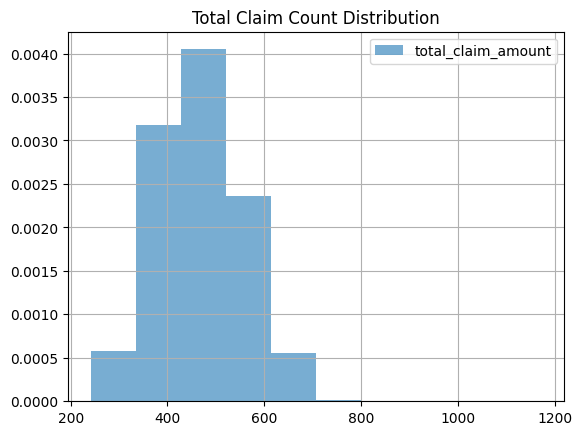

In [119]:
sev_df['total_claim_amount'].hist(legend=True, alpha=0.6, density = True)
plt.title('Total Claim Count Distribution')
plt.show()

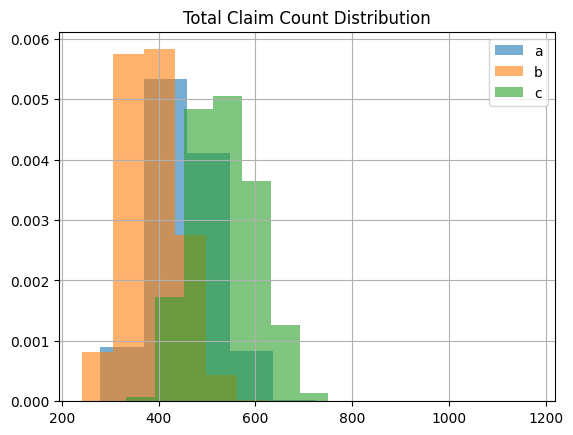

In [120]:
sev_df.groupby('variable_1')['total_claim_amount'].hist(legend=True, alpha=0.6, density = True)
plt.title('Total Claim Count Distribution')
plt.show()

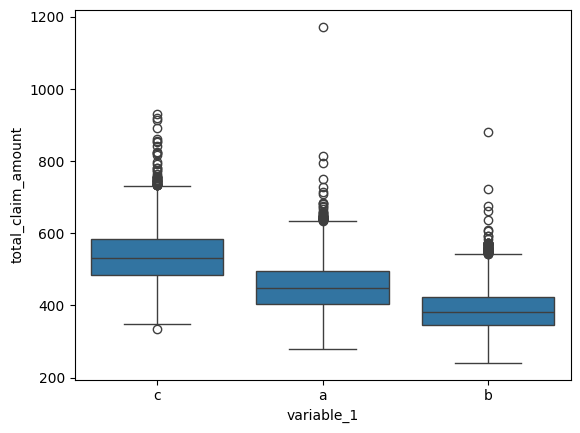

In [121]:
sns.boxplot(x = sev_df['variable_1'], y = sev_df['total_claim_amount'])
plt.show()

In [122]:
print(f'The Negative Log Likelihood of the data is {-1 * np.sum(gamma.logpdf(sev_df['total_claim_amount'], a = sev_df['gamma_shape'], loc=0, scale=1.6)):.4f}')

The Negative Log Likelihood of the data is 436942.1091
